![header](https://i.imgur.com/I4ake6d.jpg)
<img src="https://immerse-ocean.eu/img/headers/immerse-header-logo.png"  style="width: 50%;"/> 
<img src="https://www.hereon.de/cms60/res/assets/logos/hereon_logo.svg"  style="width: 50%;"/> 

# COPERNICUS MARINE FerryBox Validation use case

***

<center><h1>Notions on how to use lagragangian measurements from FerryBox (temperature (T), salinity (S)) to validate structured grid (NEMO) and unstructured grid (SCHISM) model simulations</h1></center>

***
# Table of contents
- [Introduction](#1\)-Introduction-and-description)
- [Required Python modules](#2\)-Jupyter-notebook-and-required-Python-modules)
- [About the data](#3\)-About-the-data)
- [Exercise n.1: Plot of maps](#4\)-Exercise-n.1:-Plot-of-maps)
- [Exercise n.2: -Interpolation of model data to FerryBox tracks and computation of along track statistics](#5\)-Exercise-n.2:-Interpolation-of-model-data-to-FerryBox-tracks-and-computation-of-along-track-statistics)
- [Conclusion](#6\)-Conclusion)
***

# 1) Introduction and description


[Go back to the "Table of contents"](#Table-of-contents)


Ocean models are valuable tools to predict future (forecast) or reconstruct past (hindcast) events, gain undestranding of physical processes, and test 'what if scenairos' in the context of adaptation and management strategies.
Credibility regarding the reasonable functioning of such models is gained from the validation against observational data, indicating how good the model can replicate the observed ocean state.

The objective of this exercise is to use temperature and salinity data from a ship attached FerryBox (https://www.ferrybox.org/) to perform lagrangian track validation of simulations of these variables stemming from different models, namely the CMEMS Atlantic - European North West Shelf - Ocean Physics Analysis and Forecast model [NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013](https://resources.marine.copernicus.eu/product-detail/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/INFORMATION), the high resolution NNEMO.v4.2_RC Southern North Sea configuration developed at [Helmholtz-Zentrum Hereon](https://www.hereon.de/) in the context of immerse, and the German Bight configuration operated at Hereon, using the [SCHISM unstructured grid moddeling framework](http://ccrm.vims.edu/schismweb/) for an assesment of the model performance on those variables within the south eastern German Bight.


In particular, you will:
- plot the FerryBox data in space and time
- display horizontal maps of temperature and salinity fields from the different models
- overlay on each of these the FerryBox measurements a long the track travelled by the ship

- interpolate the model output onto the lagrangian track sampled by the FerryBox in time and space
- plot the resulting curves
- compute and plot the basic errors statistics (bias, rmse, correlation) between measured and interpolated model tracks

***



The assesment code is part of the 
## IMMERSE WP8 repository
which can be obtained, after e.g. creating a local directory (in shell),

mkdir my_toolbox_code
cd my_toolbox_code

from github via

git clone git@github.com:immerse-project/Downstream-Users-Toolbox.git
cd Downstream-Users-Toolbox/immerse_ferrybox_validation


The example data to conduct the exercies is distributed with the github repository (clairify) and shortly described in  ["About the data"](#3\)-About-the-data).
And should be downloaded and unzipped into the usecase directory containing this notebook. Via (will change):

ftp ftp.hereon.de
Name: anonymous
Password: enter your email address

cd outgoing/immerse
unzip data.zip

if ftplib and zipfile are installed (e.g. conda install -c conda-forge pyftpdlib)
the download and unzipping can be executed within Python from this script.

# 2) Jupyter notebook and required Python modules

To execute this noteook a jupyter notebook clinet is necessary which can be installed for an annaconda environment 
or can be startet e.g. in a web-broswer https://jupyterhub-wekeo.apps.eumetsat.dpi.wekeo.eu/ using the Copernicus resourcess.


The python based assesment example code relies on a Python installation of e.g. annaconda ( https://docs.anaconda.com/anaconda/install/index.html ).




 and the fllowing Python modules, partially contained in an annaconda installation.

[Go back to the "Table of contents"](#Table-of-contents)

| Module name | Description |
| :---: | :---|
| **os** | [Miscellaneous operating system interfaces](https://docs.python.org/3.7/library/os.html) for managing paths, 
| **sys** | [Miscellaneous operating system interfaces](https://docs.python.org/3.7/library/os.html) for managing paths, creating directories,... |
| **glob** | [Unix style pathname pattern expansion](https://docs.python.org/3.7/library/glob.html) this module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell |
| **numpy** | [NumPy](https://numpy.org/) is the fundamental package for scientific computing with Python and for managing ND-arrays |
| **xarray** | [Xarray](http://xarray.pydata.org/en/stable/) introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. |
| **matplotlib** |[Matplotlib](https://matplotlib.org/) is a Python 2D plotting library which produces publication quality figures |
| **motuclient** |[motuclient](https://help.marine.copernicus.eu/en/articles/5211063-how-to-use-the-motuclient-within-python-environment-e-g-spyder) Extract and download gridded data through a python command line from Motu web server. Used in CMEMS context http://marine.copernicus.eu/.
| **cartopy** |[cartopy](https://scitools.org.uk/cartopy/docs/latest/) Cartopy is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses.


### Code cells allow you to enter and run Python code
Run a code cell using <code>Shift-Enter</code> or pressing the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button in the toolbar above:

### Install the needed Python modules 

**Requirement: Python version 3.7** onwards

Check your Python version:

In [1]:
!python --version

Python 3.8.6


If needed you can install the right Python version in this way:
```
conda install python=3.7
```

If you are using the standard *Anaconda* installation, you can install the modules executing the following command in a new cell:
```
conda install numpy xarray matplotlib netcdf4 dask motuclient cartopy
```

Then, as requested, please restart the kernel.

The kernel maintains the state of a notebook's computations. You can reset this state by restarting the kernel. This is done by clicking on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> in the toolbar above.

In [2]:
# conda install xarray  # uncomment an rexecute if xarray is missing

## Import the modules

In [3]:
import time
import sys
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
try:
    import motuclient
    motu=True
except:    
    motu=False
# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


import warnings
warnings.filterwarnings('ignore')

t0=time.time()

# Import third-party modules
### for plotting of the unstructured grid model data we import functions of schism.py locally from the files delivered with this notebook

In [4]:
#os.chdir('/gpfs/work/jacobb/data/immerse')
sys.path.insert(0,'./lib/') # insert path to local library schism.py
from schism import schism_setup, param


# 3) About the data

[Go back to the "Table of contents"](#Table-of-contents)

### 3.1) FerryBox Data 

"FerryBox is a through-flow system installed on board of a ship-of-opportunity (ferry, cargo ship or research vessel) to measure automatically, continuously and unattended a series of important marine parameters. The sensors installed offer the opportunity to measure physical (salinity, temperature, turbidity, …), chemical (nutrients, pH, CO2, DOC –humic compounds, oxygen) and biological (chlorophyll, phytoplankton composition, dominant/harmful species) parameters."[(eurogoos.eu)](https://eurogoos.eu/ferrybox-task-team/)

FerryBox data is available via the CMEMS marine resources e.g. as part of the [INSITU_NWS_NRT_OBSERVATIONS_013_036](https://resources.marine.copernicus.eu/product-detail/INSITU_NWS_NRT_OBSERVATIONS_013_036/DOCUMENTATION) or Hereon's [COSYNA data portal](https://codm.hzg.de/codm/). With this exercise data from the later is delivired within the subfolder 
'./data/ferrybox' containing one ship track from Nov, 5 2018.


## 3.2) Data from CMEMS NWSHELF_MULTIYEAR_PHY_004_009 

"The ocean physics analysis and forecast for the North-West European Shelf is produced using a forecasting ocean assimilation model, with tides, at 1.5 km horizontal resolution coupled with a wave model. The ocean model is NEMO (Nucleus for European Modelling of the Ocean), using the 3DVar NEMOVAR system to assimilate observations. These are surface temperature, vertical profiles of temperature and salinity, and along track satellite sea level anomaly data. The model is forced by lateral boundary conditions from the UK Met Office North Atlantic Ocean forecast model and by the CMEMS Baltic forecast product BALTICSEA_ANALYSISFORECAST_PHY_003_006. The atmospheric forcing is given by the operational ECMWF Numerical Weather Prediction model. The river discharge is from a daily climatology. Further details of the model, including the product validation are provided in the BALTICSEA_ANALYSISFORECAST_PHY_003_006. The wave model is described in BALTICSEA_ANALYSISFORECAST_PHY_003_006. Products are provided as hourly instantaneous, quarter-hourly, and daily 25-hour, de-tided, averages. The datasets available are temperature, salinity, horizontal currents, sea level, mixed layer depth, and bottom temperature. Temperature, salinity and currents, as multi-level variables, are interpolated from the model 51 hybrid s-sigma terrain-following system to 33 standard geopotential depths (z-levels) and from the model rotated grid to a regular lat-lon grid. The product is updated daily, providing a 6-day forecast and the previous 2-day assimilative hindcast. See CMEMS-NWS-PUM-004-013_014 for further details."
(https://resources.marine.copernicus.eu/product-detail/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/INFORMATION)

1. You can find info on this product and access to the download services in the [dedicated Product Page on Copernicus Marine (CMEMS) Web portal](https://resources.marine.copernicus.eu/product-detail/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/INFORMATION)
<br><br>
2. For **detailed information** about the product, please consult the **document**: [Product User Manual (PUM)](https://catalogue.marine.copernicus.eu/documents/PUM/CMEMS-NWS-PUM-004-013-014.pdf)
<br><br>
3. For information about **the quality and validation** of the product, please consult the **document**: [Quality Information Document (QUID)](https://catalogue.marine.copernicus.eu/documents/QUID/CMEMS-NWS-QUID-004-013.pdf)


Example data for Nov, 5 2018 from this product for FerryBox validation is delivered with this exercise in the folder ./data/amm15/ containing one file for the temperature output and one for the salinity output.


## 3.3) Data from Hereon 400m Southern North Sea configuration

In the context of immerse at Hereon a NEMO configuration for Southern North Sea (SNS) with a high resolution of 400m was setup based on NEMO.v4.2_RC code introducing the feature of wetting and drying. The model configuration is forced via the NWSHELF_MULTIYEAR_PHY_004_009 product at the open ocean boundaries and recviews its atmospheric forcing from outputs of the model of the German Weather Service. Outputs of the model are delivired with this exercise  within subfolder './data/nemo/' containing the land-sea mask and the surface layer temperature+salinity, corresponding to the Analysis period. 


## 3.4) Data from Hereon unstrucutured grid (SCHISM) German Bight configuration

An unstructured grid configuration for the German Bight runs preoperationally at Helmholtz-Zentrum Hereon based on the SCHISM (Semi-implicit Cross-scale Hydroscience Integrated System Model, [SCHISM](http://ccrm.vims.edu/schismweb/).
The unstructured grid representation of the German Bight consisting of ~500k nodes and ~1 million triangles elements in the horizontal and 21 terrain following sigma layers in the vertical Dimension. The horizontal resolution ranges from ~1.5 km at the open boundary to a maximum of ~50 m in the river cross sectional direction. 
At the open boundary the model is forced via hydrodynamic fields (temperature, salinity, ssh, 3D velocities) downscaled from the AMM15(NWSHELF_MULTIYEAR_PHY_004_009) Copernicus operational product for the European shelf. Atmospherically, the model is driven by outputs from the meteorological model Cosmo-EU of the German Wether Serviece (DWD). River forcing is applied climatologically at the four rivers Ems, Weser, Elbe and Eider. The Setup in furhter detail is introduced in the publication of Stanev et al. 2019(https://www.sciencedirect.com/science/article/pii/S0278434318302772).
Output of the unstructured grid model, together with the unstructured grid files and a plotting library are delivired with this exercise in './data/schism/' and './data/lib/', respectively.





## 3.5) Data Access

<div class="alert alert-block alert-warning">
    <b>Get the CMEMS User credentials</b>
<hr>
Data for the exercise are available on this notebook. To download compatible data by yourself, please be sure to have by your CMEMS User credentials, from where FerryBox data. Otherwise please get them <a href="http://marine.copernicus.eu/services-portfolio/register-now/" target="_blank">here</a>. Available via CMEMS are FerryBox data e.g. as part of the /INSITU_NWS_NRT_OBSERVATIONS_013_036/, as well as data for the opeartial model products such as NWSHELF_MULTIYEAR_PHY_004_009. Data from the Hereon models is not yet publicly accessible.
 

# Data structure overview

Data from the FerryBox and the models resides in subfolders at the level of this ipyton notebook, dowloaded together with the compressed exercise file.
Executing the following code section sets up the directory paths and creates a output directory.


## Try ftp download an unzip from within python
# The Donwload within python might time out on Cloud System such as Wekeo servers and a manual download of the exercise data is recommended

In [5]:
 #conda install ftplib

In [6]:
import zipfile

if not os.path.exists('data'): # data already unzipped
    with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
        zip_ref.extractall('./')        

In [7]:
import os
os.path.exists('data')

try:
    import ftplib   # import annaconda
except:
    print('ftplib not installed, please download data mannually as described at the beginning of this notebook')    

# download data if not already there
if ~ ((os.path.exists('data.zip')) or (os.path.exists('data'))):

    
    server = 'ftp.hereon.de'
    directory = 'outgoing/immerse/'
    fname='data.zip'

    ftp = ftplib.FTP(server)
    ftp.login()
    print('directory contains:')
    ftp.cwd(directory)
    ftp.retrlines('LIST') # list directory
    try:
        print('begin downloading data (~2.6 gb) this could take a moment wait for "finished download"')
        ftp.retrbinary("RETR {}".format(fname), open(fname, 'wb').write) # download file
        print('finished download')
    except:    
        print('error downloading data')    
else:
        print('zip or data direcotry already present')                                                    
                                     
                                     
# unzip the data                                     
if os.path.exists('data.zip') and ~os.path.exists('data'):  
    print('unzip')
    try:
        import zipfile
        with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
            zip_ref.extractall('./')        
            print('done extracting zip archiv')
        
    except:            
        print('library zipfile missing data needs to be extracted manually')           

        

directory contains:
begin downloading data (~2.6 gb) this could take a moment wait for "finished download"
error downloading data
unzip
library zipfile missing data needs to be extracted manually


## Inspect directories

In [8]:
# We create a function CheckDir to create a folder if non existent
# and return its contents otherwise to list our exercise files
def checkDir(outPath):
    "function for creating a path, if needed"
    if not os.path.exists(outPath):
        #os.makedirs(outPath)
        print('directory missing make sure to get the exercise da')
        #print('Creating output foler: '+str(outPath))
    else:
        print('directory {:s} already exists'.format(outPath))    
        print('containing:')
        print(os.listdir(outPath))

# try download ftp

        
# Path for netcdf files as distributed within tar file
fb_dir = './data/ferrybox'
amm_dir = './data/amm15/'
nemo_dir = './data/nemo/'
schism_dir = './data/schism/'
out_path = './output/' # non existent outputfolder to save images
lbdir= './data/lib'
#Check the current directories:
for diri in fb_dir, amm_dir, nemo_dir, schism_dir, out_path, lbdir:
    checkDir(diri)

if not os.path.exists(out_path):    
    os.makedirs(out_pathh)
        

directory ./data/ferrybox already exists
containing:
['HZG-Ferrybox_Cux-HelgoNR80378.nc']
directory ./data/amm15/ already exists
containing:
['metoffice_foam1_amm15_NWS_TEM_b20181107_hi20181105.nc', 'metoffice_foam1_amm15_NWS_SAL_b20181107_hi20181105.nc']
directory ./data/nemo/ already exists
containing:
['mask.nc', 'SNS_sst_sss_20181105.nc']
directory ./data/schism/ already exists
containing:
['hgrid.gr3', 'param.nml', 'vgrid.in', 'hgrid.ll', 'salinity_673.nc', 'temperature_673.nc']
directory ./output/ already exists
containing:
[]
directory ./data/lib already exists
containing:
['__pycache__', 'schism.py']


If you are using the standard *Anaconda* installation, you can install the modules executing the following command in a new cell:
```
conda install numpy xarray matplotlib netcdf4 dask motuclient cartopy
```

- The folder ./data/ferrybox contains the ferrybox netcdf file 'HZG-Ferrybox_Cux-HelgoNR80378.nc'
- ./data/amm15/ The temperature and Salinity output from CMEMS NWSHELF_MULTIYEAR_PHY_004_009 model
    - 'metoffice_foam1_amm15_NWS_SAL_b20181107_hi20181105.nc'
    - 'metoffice_foam1_amm15_NWS_TEM_b20181107_hi20181105.nc'
- ./data/nemo/ contains extracts of the Hereon Nemo SNS model
    - 'mask.nc', the land sea mask information
    - 'SNS_sst_sss_20181105.nc', and the surface temperature salinity fields for the day to be validated
- ./data/schism/ contains the grid and data files from the SCHISM unstructured model setup
    - 'hgrid.gr3', horizontal grid in local projection
    - 'hgrid.gr3', horizontal grid in longitude latitude 
    - 'vgrid.in',  the vertical grid
    - 'param.nml', the paraneter namelist to deduct startdate information
    - 'temperature_673.nc'
    - 'salinity_673.nc',  data files on temperature and salinity for one day



# Data structure overview
### All necessary data is delivered with this ercise, however in the following it is stated how additional data could be obtained:

### 3.5.1) FerryBox via ftp
FerryBox data from CMEMS can be retrived using wget via (in Linux environment):
 
    wget -r  -c -v -nc -P prefix --directory-prefix=./FB --ftp-user=cmemsuser --ask-password ftp://nrt.cmems-du.eu/Core/INSITU_NWS_NRT_OBSERVATIONS_013_036/nws_multiparameter_nrt/monthly/FB/201811/'*' 
    
with cmemsuser, being your user name.


### 3.5.2) CMEMS operational model data whtih domain subsetting via motuclient from within python

The configuration of the motuclient here is orientated after the CMEMS tutorial:
https://help.marine.copernicus.eu/en/articles/5211063-how-to-use-the-motuclient-within-python-environment-e-g-spyder
using the functions of D. Bazin, E. DiMedio, J. Cedillovalcarce, C. Giordan.


In our example we validate the HEREON structured(NEMO SNS) and unstructured (SCHISM German Bight) 2018 model runs against FerryBoxData with the operational CMEMS model as reference. Since the near real time (nrt) 1.5 km CMEMS operational product is --due to memory restrictions-- hosted on CMEMS data portal https://resources.marine.copernicus.eu/products for a time window of ~2 years, for data download for this tutorial we would rely on the coarser 0.067 degree resolution multiyear reanalysis product ([NWSHELF_MULTIYEAR_PHY_004_009](https://resources.marine.copernicus.eu/product-detail/NWSHELF_MULTIYEAR_PHY_004_009/INFORMATION)).

For the data download the cmems credencials are required and requested as input during the cell execution.

In [9]:
download_data=False #skip data download for cell execution
if download_data:
    # The used functions and dictionaries are adapted from the authos:
    __author__ = "Copernicus Marine User Support Team"
    __copyright__ = "(C) 2021 E.U. Copernicus Marine Service Information"
    __credits__ = ["E.U. Copernicus Marine Service Information"]
    __license__ = "MIT License - You must cite this source"
    __version__ = "202105"
    __maintainer__ = "D. Bazin, E. DiMedio, J. Cedillovalcarce, C. Giordan"
    __email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"



    # We define create a new download folder and define the data for data donwload for in this case NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013-TDS
    downloaddir='./data/cmems_nws/'
    checkDir(downloaddir) # create outputfolder for cmems download
    dateday="2018-11-05" # Select day of FerryBox track day (FerryBox example data was provided with the notebook)



    # An options calss translates the dictionary for the motu client api
    class MotuOptions:
        def __init__(self, attrs: dict):
            super(MotuOptions, self).__setattr__("attrs", attrs)

        def __setattr__(self, k, v):
            self.attrs[k] = v

        def __getattr__(self, k):
            try:
                return self.attrs[k]
            except KeyError:
                return None

    # In the manual we classyfy the product ID and temporal spatial limits as well as the variable we want to download        
    data_request_options_dict_manual = {
        "service_id": "NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013-TDS",
        "product_id": "",
        "date_min": dateday+" 00:30:00",
        "date_max": dateday+" 23:30:00",
        "longitude_min": 4.,
        "longitude_max": 12.,
        "latitude_min": 51.,
        "latitude_max": 57.,
        "depth_min": 0.493,
        "depth_max": 0.4942,
        "variable": ["thetao"],
        "motu": "https://nrt.cmems-du.eu/motu-web/Motu",
        "out_dir": downloadir,
        "out_name": "",
        "auth_mode": "cas",
        "user": input('enter your cmems user acount name: '),
        "pwd": input('enter your cmems user acount password: ')
    }



    # overwrite the dictionary fields for server and service id corresponding to NWSHELF_MULTIYEAR_PHY_004_009. 
    data_request_options_dict_manual["motu"]="https://my.cmems-du.eu/motu-web/Motu"
    data_request_options_dict_manual["service_id"]="NWSHELF_MULTIYEAR_PHY_004_009-TDS"
    data_request_options_dict_manual["date_min"]=dateday+" 00:00:00"
    data_request_options_dict_manual["date_max"]=dateday+" 23:00:00"


    # We make the call to the motuclient download api, looping over the temperature and salinity product
    # updating product name and variables

    #iterate over salt and temperature product of NWSshelf output
    variables=['SAL','TEM']    # name elements used for downloaded outputfiles
    varnames=["so", "thetao"]  # variable names for salinity and temperature in the respective data product
    cmems_model_fnames=[]
    for var, varname in zip(variables,varnames):

        # config for AMM15
        #outname='_'.join(('Amm15',var,date))+'.nc'  #'Amm15_'+var+  # nrt product )(not available for period)
        #product='MetO-NWS-PHY-hi-'+var                              # nrt product )(not available for period)    

        #Config for 7km multiyear product
        print('downloading '+var)
        outname='_'.join(('Amm7',var,dateday))+'.nc'  #'Amm15_'+var+    #geneate file output name by variable
        product='cmems_mod_nws_phy-{:s}_my_7km-2D_PT1H-i'.format(var) #geneate product identifier by variable name

        #update those in the dictionary
        data_request_options_dict_manual["product_id"]=product
        data_request_options_dict_manual["out_name"]=outname  
        data_request_options_dict_manual["variable"]=[varname,]

        # call motu client with opethions for download
        relpath=downloadir+outname
        print(relpath)
        if not(os.path.exists(relpath)):
            motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_manual))

        else:
            print('files already downloaded')
        cmems_model_fnames.append(relpath)

In [10]:
download_data=False #skip data download for cell execution
if download_data:
    ## After download we make a test plot of the data    
    for fname,varname in zip(cmems_model_fnames,varnames):
        plt.figure()
        ds=xr.open_dataset(fname)
        ds[varname][0,:].plot()


***How to download the products?***

If you need some help about the different services for downloading the CMEMS products, please check this [tutorial](
https://marine.copernicus.eu/tutorials/how-to-download-products-service-release-septembre-2015/)

# 4) Exercise-n.1:-Plot-of-maps

In this exercise it is demonstrated how to access the netcdf data from the different source, individulay and how to plot it in space.
[Go back to the "Table of contents"](#Table-of-contents)


## 4.1) FerryBox

### Setup a class using xarray to read the different fields from the FerryBox netcdf file, and applying the quality information to mask data entries of insufficient quality


In [11]:
# Ferrbox Data


fbfiles=glob.glob(fb_dir+'/*.nc')
for file in fbfiles:
    print(file)
    
class ferryBox:
    """ FerrBox data class """   
    def __init__(self, fbfile,timerange=None,spacerange=None):
        fb_ds=xr.open_dataset(fbfile)
        """arguments: fbfile: ferrbox netcdft file
                      timrange datetime object: (starttime, endtime)
                      spacerange: (lonmin,lonmax, latmin,latmax)
        """
        
        # Restict space time extended of Ferrybox track to be loaded
        if (timerange != None) and (spacerange != None):
            fb_ds=fb_ds.sel(TIME=slice(timerange[0],timerange[-1]),LONGITUDE=slice(spacerange[0],spacerange[1]),LATITUDE=slice(spacerange[2],spacerange[3]))
        elif (timerange != None):
            fb_ds=fb_ds.sel(TIME=slice(timerange[0],timerange[-1]))
        elif (spacerange != None):
            fb_ds=fb_ds.sel(LONGITUDE=slice(spacerange[0],spacerange[1]))
        
        
        # load Data
        self.lon=fb_ds['LONGITUDE'][:].values
        self.lat=fb_ds['LATITUDE'][:].values
        self.time=fb_ds['TIME'][:].values
        self.sst=fb_ds['TEMP'][:].values
        self.sss=fb_ds['PSAL'][:].values

        # quality control flags: 
        # [0 1 2 3 4 9]
        # [no_qc_performed good_data probably_good_data bad_data_that..
        # remove data points with quality flags > 2
        self.Tqc=fb_ds['TEMP_QC'][:].values
        self.Sqc=fb_ds['PSAL_QC'][:].values

        self.sst[self.Tqc[:,0]>2]=np.nan
        self.sss[self.Sqc[:,0]>2]=np.nan
        self.sst=np.ma.masked_array(self.sst,mask=self.Tqc[:,0]>2)
        self.sss=np.ma.masked_array(self.sss,mask=self.Sqc[:,0]>2)
        
# open ferryBox file and compare against models
fbfile=fbfiles[0]            
fb=ferryBox(fbfile)


./data/ferrybox/HZG-Ferrybox_Cux-HelgoNR80378.nc


## Resampling
The used FerryBox data contains measurements ~each 20s, while the model data ranges between 15 minute and hourly resolution. Therefore FerryBox is subsampled to at least 5 minute distanced measurements to save on computational resources:

In [12]:
# The Feery
# Find the entries at least 15 minutes appart

minutes=1 # minute subsampling
i0=0
keep_indices=[i0]
for ti in range(len(fb.time)):
    if (fb.time[ti]-fb.time[keep_indices[-1]])/np.timedelta64('1','m')>=minutes:
        keep_indices.append(ti)
print(keep_indices)    

fb.lon=fb.lon[keep_indices]
fb.lat=fb.lat[keep_indices]
fb.time=fb.time[keep_indices]
fb.sst=fb.sst[keep_indices]
fb.sss=fb.sss[keep_indices]


[0, 3, 6, 10, 13, 17, 21, 24, 28, 31, 34, 37, 40, 44, 47, 50, 53, 56, 60, 63, 67, 70, 74, 77, 81, 84, 87, 90, 93, 97, 100, 103, 106, 109, 113, 116, 119, 122, 125, 129, 132, 136, 140, 143, 147, 150, 153, 156, 159, 163, 166, 169, 172, 175, 179, 182, 185, 188, 191, 195, 198, 202, 205, 209, 212, 216, 219, 222, 225, 228, 232, 235, 238, 241, 244, 248, 251, 254, 257, 260, 264, 267, 271, 275, 278, 282, 285, 288, 291, 294, 298, 301, 304, 307, 310, 314, 317, 320, 323, 326, 330, 333, 337, 340]


### Now plot the FerryBox track just previously loaded using Cartopy
Looping over the data contained variables Sea surface Temperature and Sea surface Salinity,
Showing a temperature decrease and salinity increase, as the Ferry travels from Cuxhaven located in the outer Ems estuary
to the Island of Helgoland.

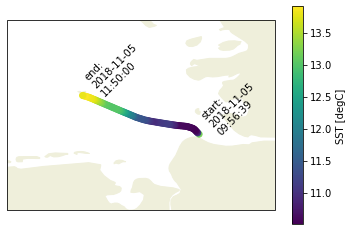

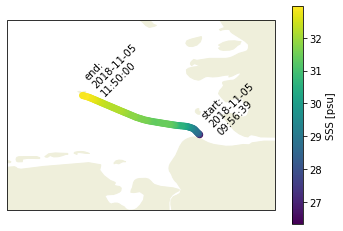

In [13]:
proj=projection=ccrs.PlateCarree()

for i in range(2): #loop to plot surface temperature (fb.sst)  and surface salinity(fb.sst)
    plt.figure()
    if i==0:
        data=fb.sst
        label='SST [degC]'
    else:    
        data=fb.sss
        label='SSS [psu]'
 
    ax = plt.axes(projection=proj)    
    ax.set_extent((fb.lon.min()-.5,fb.lon.max()+.5,fb.lat.min()-.5,fb.lat.max()+.5))
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor=cfeature.COLORS['land'])
    ax.add_feature(land_10m,zorder=-2)
    ph=plt.scatter(fb.lon,fb.lat,c=data,transform=proj,vmin=data.min(),vmax=data.max())
    ch=plt.colorbar(ph)
    ch.set_label(label)
    # add cruise start and end time 
    ax.text(fb.lon[0],fb.lat[0],'start:\n'+str(fb.time[0]).replace('T','\n')[:19],rotation=45,transform=proj)
    ax.text(fb.lon[-1],fb.lat[-1], 'end:\n'+str(fb.time[-1]).replace('T','\n')[:19],rotation=45,transform=proj)


## 4.2) Data from NWSHELF_MULTIYEAR_PHY_004_009
### Search for the by-variable file outputs files  and open it using xarray and use xarrays embeded plot functionality

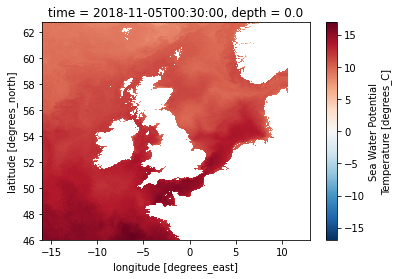

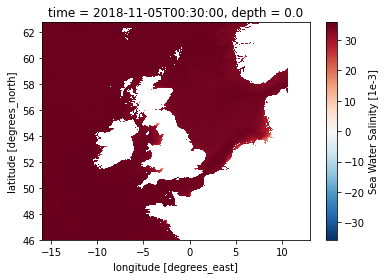

In [14]:
# load amm



# search for files by filename pattern
tfiles=np.sort(glob.glob(amm_dir+'*TEM*nc'))
sfiles=np.sort(glob.glob(amm_dir+'*SAL*nc'))

#amm_tnc=xr.open_mfdataset(tfiles) #temperature file acces
#amm_snc=xr.open_mfdataset(sfiles) #salinity file acces

# access data, surface layer (depth=0) only needed for FerryBox
amm_tnc=xr.open_mfdataset(tfiles).sel(depth=0) #temperature file acces
amm_snc=xr.open_mfdataset(sfiles).sel(depth=0) #salinity file acces

#create grid
amm_lon,amm_lat=np.meshgrid(amm_tnc.lon.values,amm_tnc.lat.values)
amm_time=amm_tnc['time'].values

# use ckd nearest neighbour search tree for faster nearest neighbour interpolation
from scipy.spatial import cKDTree
nn_search_tree=cKDTree(list((xi,yi) for xi,yi in zip(amm_lon.flatten(),amm_lat.flatten())))

# list the data content
#print(amm_tnc)


#plot first time step for surface data of temperature variable 'thetao' and salinity variable 'so' using xarrays direct plot functionality
amm_tnc['thetao'][0,:,:].plot() 
plt.figure()
amm_snc['so'][0,:,:].plot() 


# 4.3)  DATA From Hereon SNS NEMO CONFIG
- load NEMO SNS data and landmask files
- Plot using cartopy

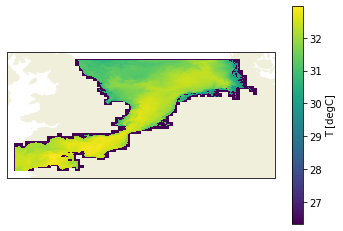

In [15]:
# NEMO netcdf file

# Open the netcdf dataset handles via xarray
# for the data file
nemofile=os.path.join(nemo_dir,'SNS_sst_sss_20181105.nc') 
nemo_ds=xr.open_dataset(nemofile)

#and the land sea mask
land_sea_mask_file=os.path.join(nemo_dir,'mask.nc')       
mask_ds=xr.open_dataset(land_sea_mask_file)

# get grid information stored in mask file and time information in data file
LON=mask_ds['glamt'][0,:].values
LAT=mask_ds['gphit'][0,:].values
time_nemo=nemo_ds['time_counter'][:].values
LandSeaMask=np.asarray(mask_ds['tmask'][0,0,:,:],bool) #load the land sea mask



# For track collocation in this case we will use nearest neighbour interpolation
# addd Nan Values from sst field to mask
sst=nemo_ds['sst'][0,:,:].values
sst=np.ma.masked_array(sst,mask=np.isnan(sst))

# The array LON2 based on which the neareast neighbour will be looked up 
#is modified at masked values to exclude them from the search
LON2=LON.copy()
LON2[sst.mask | ~LandSeaMask ]=9999 
LON2flat=LON2.flatten()
LATflat=LAT.flatten()


# Now We plot the fields of model using cartopy
# set up a colormap with bad value areas in white
import copy
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad('w')

# initilize cartipy projection abd set it to an extent
proj=projection=ccrs.PlateCarree()
ax = plt.axes(projection=proj)    
ax.set_extent((LON.min()-.5,LON.max()+.5,LAT.min()-.5,LAT.max()+.5))

# Plot the SST field and fill the land areay
ax.pcolor(LON[0,:],LAT[:,0],sst,cmap=cmap,transform=proj,shading='auto') 
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m,zorder=-2)

# add a colorbar
ch=plt.colorbar(ph)
ch.set_label('T [degC]')



# 4.4) DATA From Hereon SCHISM ugrid model
- Access schism data files
- used plot functions embeded from schism-objec-class(schism.py)


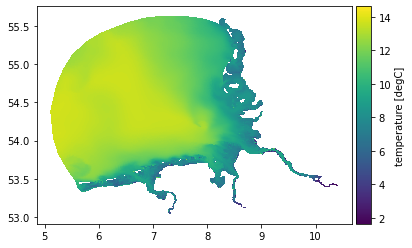

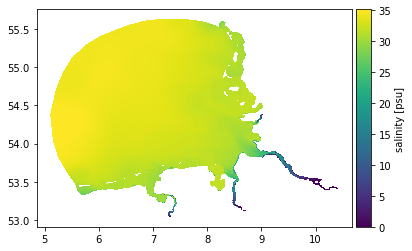

In [16]:
# SCHISM grid and netcdf file
ncdir=schism_dir

# load schism grid structure using third party calss
cwd=os.getcwd()
os.chdir(schism_dir)
s=schism_setup() 
os.chdir(cwd)


# initiate schism file acces
tfile=ncdir+'temperature_673.nc'
sfile=ncdir+'salinity_673.nc'
try:
    s.tnc=xr.open_dataset(tfile).sel(nSCHISM_vgrid_layers=-1)
    s.snc=xr.open_dataset(sfile).sel(nSCHISM_vgrid_layers=-1)
except: # a later update of the data was restricted to surface data only
    s.tnc=xr.open_dataset(tfile)
    s.snc=xr.open_dataset(sfile)

# load date reference from parameter file to conver simulation
# times stored in netcdf to dates
p=param(ncdir+'/param.nml')
reftime=np.datetime64('{:04.0f}-{:02.0f}-{:02.0f}T{:02.0f}:00:00.000000'.format(p.get_parameter('start_year'),p.get_parameter('start_month'),p.get_parameter('start_day'),p.get_parameter('start_hour') ))
schism_dates=reftime+np.asarray(s.tnc['time'].values,np.timedelta64(1,'s'))

# plot temperature an salinity fields
ph,ch,axs=s.plotAtnodes(s.tnc['temperature'][0,:])
ch.set_label('temperature [degC]')
plt.figure()
ph,ch,axs=s.plotAtnodes(s.snc['salinity'][0,:])
ch.set_label('salinity [psu]')

## 4.5) Map plots with FerryBox scatter overlay

Model fields after about half the travelling time are overlayed with the FerryBox measurements as scatter plot. 
The simalirity between colors is a first indicator on how good the match is  and how well the models replace the spatial gradiends. The plots are executed in a loop first for sst thand fo sss.

Plotting sst [°C]
sst [°C]
Plotting sss [psu]


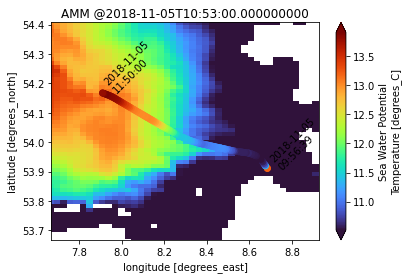

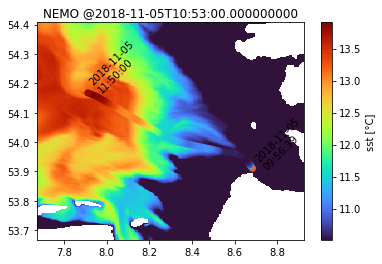

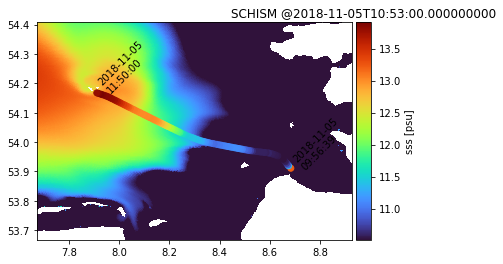

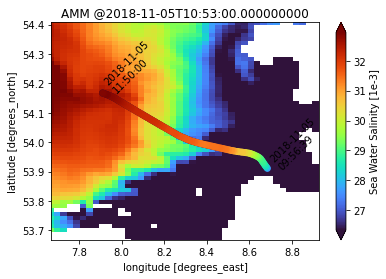

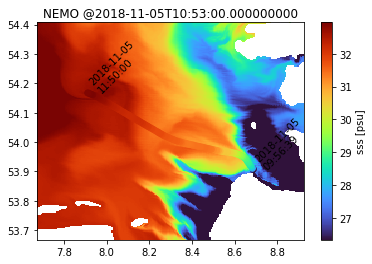

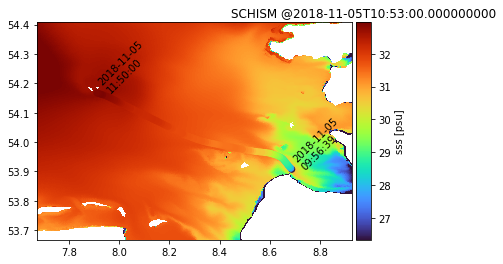

In [17]:
# use a central time step of the FerryBox track to plot maps with FerryBox track overlay
cdate=fb.time[np.int(np.median(np.arange(len(fb.time))))] 
date_str=str(cdate)[:16]

#define color map for plotting
import copy
cmap = copy.copy(plt.cm.get_cmap("turbo"))
cmap.set_bad('w')


# create scatter plot function for ferrbox data
def scatter_plot_fb(data,vmin,vmax,axs=None):
    "scatter plot of data on prescibed axes or default matplotlib gca"
    if axs==None:
        plt.scatter(fb.lon,fb.lat,c=data,vmin=vmin, vmax=vmax, cmap=cmap,edgecolor=None)
        plt.text(fb.lon[0],fb.lat[0],str(fb.time[0]).replace('T','\n')[:19],rotation=45)
        plt.text(fb.lon[-1],fb.lat[-1], str(fb.time[-1]).replace('T','\n')[:19],rotation=45)
    else:
        axs.scatter(fb.lon,fb.lat,c=data,vmin=vmin, vmax=vmax, cmap=cmap,edgecolor=None)
        axs.text(fb.lon[0],fb.lat[0],str(fb.time[0]).replace('T','\n')[:19],rotation=45)
        axs.text(fb.lon[-1],fb.lat[-1], str(fb.time[-1]).replace('T','\n')[:19],rotation=45)
    
    
#Restrict the display axis depending on FerryBox route
ds=0.24
ax=(fb.lon.min()-ds,fb.lon.max()+ds,fb.lat.min()-ds,fb.lat.max()+ds )

# Loop twice to first plott sst followed by sss
for i,data in enumerate([fb.sst,fb.sss]):
    
    # set the labels and netcdf name indicators depnging on variable
    if i==0: # sst
        label='sst [°C]'
        varname_amm='thetao'
        amm_nc=amm_tnc
        varname_nemo='sst'
        varname_schism='temperature'
        s.nc=s.tnc
    else: #sss
        label='sss [psu]'   
        varname_amm='so'
        amm_nc=amm_snc
        varname_nemo='sss'
        varname_schism='salinity'
        s.nc=s.snc
    print('Plotting '+label)
    
    # set minimum and maximum displayed color range according to measurement
    vmin,vmax=np.nanmin(data),np.nanmax(data)

    # Amm 15 model
    plt.figure()
    amm_nc_intp=amm_nc.interp(time=date_str) #interplo
    amm_nc_intp[varname_amm].plot(cmap=cmap,vmin=vmin,vmax=vmax)
    plt.scatter(fb.lon,fb.lat,c=fb.sst,vmin=vmin, vmax=vmax, cmap=cmap,edgecolor=None)
    ch.set_label(label)
    plt.title('AMM @' +str(cdate))
    
    #FerryBox data Overlay
    scatter_plot_fb(data,vmin,vmax)    
    plt.axis(ax)
    

    # NEMO model 
    plt.figure()
    nemo_dsi=nemo_ds.interp(time_counter=cdate)
    plotdata=nemo_dsi[varname_nemo]
    plotdata=np.ma.masked_array(plotdata,mask=np.isnan(sst) | ~LandSeaMask)
    ph=plt.pcolormesh(LON,LAT,plotdata,cmap=cmap,vmin=vmin,vmax=vmax)
    ch=plt.colorbar()
    ch.set_label(label)
    plt.title('NEMO @' +str(cdate))
    
    #FerryBox data Overlay
    scatter_plot_fb(data,vmin,vmax)    
    plt.axis(ax)

    # schism model
    seconds_since_simstart=(cdate-schism_dates[0])/np.timedelta64(1,'s')+s.tnc['time'][0].values    
    plt.figure()    
    s.nc_intp=s.nc.interp(time=seconds_since_simstart)
    if i==0:
        # interp time and select triangle nodes and surface layer for spatial interpolation  
        ph,ch,axs=s.plotAtnodes(s.nc_intp[varname_schism],cmap=cmap)
        ph.set_clim((vmin,vmax))
        print(label)
        ch.set_label(label)
    else:    
        ph2,ch2,axs=s.plotAtnodes(s.nc_intp[varname_schism],cmap=cmap)
        ph2.set_clim((vmin,vmax))
        ch2.set_label(label)
    plt.title('SCHISM @' +str(cdate))
    scatter_plot_fb(data,vmin,vmax,axs=axs)    
    #plt.axis(ax)
    axs.axis(ax)

The Visual comparisons indicate, that all models roughly follow the positive sst gradient from Cuxhaven in the south East towards Helgoland island, with a tendenncy to overestimate the temperature, which is the smallest for tne NEMO SNS model. This is similarly the case for the ss fields, where SCHISM and NEMO-SNS areboth close to the measurements along track.

# 5) Exercise-n.2:-Interpolation of model data to FerryBox tracks and computation of along track statistics  

In the following for a more accurate co-location the model data will be interpolated in time in space to match the sampling along the route of the Ferry. For speeding up the process linear time plus nearest neighbour interpolation is used for the structured grid models.

[Go back to the "Table of contents"](#Table-of-contents)

In [18]:
# bilinear interpolation functions as (slower, smother) alternative for nearest neighbour interpolation
def get_4neighbours(x2d,y2d,bdx,bdy,tree2d=None):
    """ get 4 neighbours for bilinear interlation for each node on schism boundary """
    bdcoords=np.asarray(list(zip(bdx,bdy)))
    if tree2d==None:
        tree2d=cKDTree(list(zip(x2d.flatten(),y2d.flatten())))	
    dd,nn=tree2d.query(bdcoords,k=1)
    ii0,jj0=np.unravel_index(nn,y2d.shape)

    indsx=[]
    indsy=[]

        
    for i in range(len(ii0)):
        xgt0=(x2d[ii0[i],jj0[i]]-bdx[i])>0
        ygt0=(y2d[ii0[i],jj0[i]]-bdy[i])>0
        
        if xgt0 & ygt0:  # UR
            #indx=[[1, 2],[3, 4]]
            indx=[[ii0[i]-1, ii0[i]],[ii0[i]-1, ii0[i]]]
            indy=[[jj0[i]-1, jj0[i]-1],[jj0[i], jj0[i]]]
        elif (xgt0==True) & (ygt0==False):  # LR
            indx=[[ii0[i], ii0[i]+1],[ii0[i], ii0[i]+1]]
            indy=[[jj0[i]-1, jj0[i]-1],[jj0[i], jj0[i]]]
        
        elif (xgt0==False) & (ygt0==True):  # UL
            indx=[[ii0[i]-1, ii0[i]],[ii0[i]-1, ii0[i]]]
            indy=[[jj0[i], jj0[i]],[jj0[i]+1, jj0[i]+1]]
        
        elif (xgt0==False) & (ygt0==False):  # LL
            indx=[[ii0[i], ii0[i]+1],[ii0[i], ii0[i]+1]]
            indy=[[jj0[i], jj0[i]],[jj0[i]+1, jj0[i]+1]]

        indsx.append(np.asarray(indx).T)	
        indsy.append(np.asarray(indy).T)	
        
        
        #check
        if (np.sign(x2d[np.asarray(indx).T,np.asarray(indy).T]-bdx[i])==np.asarray([[-1,1],[-1,1]]))[0].min() & (np.sign(y2d[np.asarray(indx).T,np.asarray(indy).T]-bdy[i])==np.asarray([[-1,-1],[1,1]]))[0].min():
            pass
        else:
            print(i)
            break
            
    #increase performance
    indsx=np.asarray(indsx)
    indsy=np.asarray(indsy)
        
        
    return indsx,indsy

def bilin3(x,y,v,indsx,indsy,bdx,bdy,calcw=True,w1=None,w2=None,w3=None,w4=None):
    """ bilinear interpolation """
    interped=[]
    if (calcw==True):
        div_dxdy=[]
        dxi=[]
        dyi=[]
        for i in range(len(indsx)):
            indx=indsx[i]
            indy=indsy[i]
            div_dxdy.append(1/((x[indx[-1,-1],indy[-1,1]]-x[indx[0,0],indy[0,0]])*(y[indx[-1,-1],indy[-1,1]]-y[indx[0,0],indy[0,0]])))
            dxi.append([x[indx[-1,-1],indy[-1,1]]-bdx[i],bdx[i]-x[indx[0,0],indy[0,0]]])
            dyi.append(np.asarray(([y[indx[-1,-1],indy[-1,-1]]-bdy[i],bdy[i]-y[indx[0,0],indy[0,0]]])))
            div_dxdy[i]
            dxi[i]
            v[indx,indy]
            dyi[i]
            interped.append(div_dxdy[i]*np.matmul(dxi[i],np.matmul(v[indx,indy].T,dyi[i])))	
            # rewire such that no transpose needed
        dxi=np.asarray(dxi)
        dyi=np.asarray(dyi)

        div_dxdy=np.asarray(div_dxdy)
        w1=div_dxdy*dxi[:,0]*dyi[:,0] 
        w2=div_dxdy*dxi[:,0]*dyi[:,1]
        w3=div_dxdy*dxi[:,1]*dyi[:,0]
        w4=div_dxdy*dxi[:,1]*dyi[:,1]
        #print(v[indsx,indsy])
        return interped,w1,w2,w3,w4
    else: #use precalculated
        v=v[indsx,indsy]
        return  w1 * v[:,0,0] +w2*v[:,1,0] + w3*v[:,0,1] + w4 * v[:,1,1]    
    

In [19]:
# create a class element representing the interpolated
# trnsect with fields corresponding to FerryBox class
class interp_trans:
    def __init__(self, n): 
        self.lon=np.zeros(n)
        self.lat=np.zeros(n)
        self.time=np.zeros(n,np.datetime64(1,'s'))
        self.sst=np.zeros(n)
        self.sss=np.zeros(n)

nemo_trans=interp_trans(len(fb.time))
amm_trans=interp_trans(len(fb.time))
schism_trans=interp_trans(len(fb.time))


amm_bilin_interp=True # use bilin interp
#amm_trans.sst2=amm_trans.sst*0
#amm_trans.sss2=amm_trans.sss*0
        
product_labels=['fb','amm','nemo_sns','schism']


amm_time=np.asarray([np.datetime64(ti) for ti in amm_time])

#import time        
# Loop over the FerryBox measurements and interpolate the model data correspondingly in space and time
for i,date in enumerate(fb.time):
    #print(i)
    print('{:d}/{:d}'.format(i+1,len(fb.time)))
    
    # Coordinates of the FerryBox at the current time
    loni,lati=fb.lon[i],fb.lat[i]

    date_str=str(date)[:16] # convert date to string to make compatible 
    #to amm15  cftime.DatetimeGregorian in interpolation call

    if False: # alternative interpolation method not used due to be too slow.
        # make use of xarrays advanced (linear)interpolation for collocation
        xq=xr.DataArray([loni,],dims='z')
        yq=xr.DataArray([lati,],dims='z')
        #amm_tnc_intp=amm_tnc.interp(time=date,longitude=xq,latitude=yq) # valid for amm7
        #amm_snc_intp=amm_snc.interp(time=date,longitude=xq,latitude=yq)

        # to slow
        amm_tnc_intp=amm_tnc.interp(time=date_str,lon=xq,lat=yq) #amm 15
        amm_snc_intp=amm_snc.interp(time=date_str,lon=xq,lat=yq)

        #amm_tnc_intp=amm_tnc.interp(time=date_str,lon=xq,lat=yq,method='nearest')
        #amm_snc_intp=amm_snc.interp(time=date_str,lon=xq,lat=yq,method='nearest')


    # instead to speed up find previous and next model time step to linear interpolate in time
    # and using nearest neighbour in space
    #bilin interp

    # get cooresponding time indices and weights
    time_nn=np.asarray(np.argsort(np.abs(date-amm_time))[:2])
    deltaT=np.abs(date-np.asarray(amm_time)[time_nn])
    w=1-deltaT/deltaT.sum()  
    
    ## amm bilinear
    #bilin interp
    if amm_bilin_interp:
        T1=amm_tnc_intp=amm_tnc['thetao'][time_nn[0],:].values
        S1=amm_tnc_intp=amm_snc['so'][time_nn[0],:].values

        T2=amm_tnc_intp=amm_tnc['thetao'][time_nn[0],:].values
        S2=amm_tnc_intp=amm_snc['so'][time_nn[0],:].values
        #t0=time.time()
        
        indsx,indsy=get_4neighbours(amm_lon,amm_lat,[loni,],[lati,],tree2d=nn_search_tree)

        tintp1,w1,w2,w3,w4=bilin3(amm_lon,amm_lat,T1,indsx,indsy,[loni,],[lati,],calcw=True,w1=None,w2=None,w3=None,w4=None)
        tintp2=bilin3(amm_lon,amm_lat,T2,indsx,indsy,[loni,],[lati,],calcw=False,w1=w1,w2=w2,w3=w3,w4=w4)

        sintp1=bilin3(amm_lon,amm_lat,S1,indsx,indsy,[loni,],[lati,],calcw=False,w1=w1,w2=w2,w3=w3,w4=w4)
        sintp2=bilin3(amm_lon,amm_lat,S1,indsx,indsy,[loni,],[lati,],calcw=False,w1=w1,w2=w2,w3=w3,w4=w4)

        amm_trans.sss[i]=sintp1[0]*w[0]+sintp2[0]*w[1]
        amm_trans.sst[i]=tintp1[0]*w[0]+tintp2[0]*w[1]
        amm_trans.lon[i]=loni#amm_tnc_intp.lon.values[0] # amm15
        amm_trans.lat[i]=lati#amm_tnc_intp.lat.values[0]
    else:    
        ## amm nearest neighour
        #use nearest neighbour search tree and expand 1D indices too 2D i,j index
        nn=nn_search_tree.query((loni,lati))[1]
        nni,nnj=np.unravel_index(nn,amm_lon.shape)

        amm_trans.sss[i]=amm_snc['so'][time_nn[0],nni,nnj].values*w[0]+amm_snc['so'][time_nn[1],nni,nnj].values*w[1]
        amm_trans.sst[i]=amm_tnc['thetao'][time_nn[0],nni,nnj].values*w[0]+amm_tnc['thetao'][time_nn[1],nni,nnj].values*w[1]
        amm_trans.lon[i]=amm_lon[nni,nnj]#amm_tnc_intp.lon.values[0] # amm15
        amm_trans.lat[i]=amm_lat[nni,nnj]#amm_tnc_intp.lat.values[0]
    amm_trans.time[i]=date



    

    # in case of coast amm7 model we take care of NaN close to transect using nearest neighbour interp
    #print(amm_snc_intp['so'].values[0])
    #if np.isnan(amm_snc_intp['so'].values[0]):
        #amm_tnc_intp=amm_tnc.interp(time=date,longitude=xq,latitude=yq,method='nearest')
        #amm_snc_intp=amm_snc.interp(time=date,longitude=xq,latitude=yq,method='nearest')
    #    amm_tnc_intp=amm_tnc.interp(time=date_str,lon=xq,lat=yq,method='nearest')
    #    amm_snc_intp=amm_snc.interp(time=date_str,lon=xq,lat=yq,method='nearest')
    #amm_trans.sss[i]=amm_snc_intp['so'].values[0]
    #amm_trans.sst[i]=amm_tnc_intp['thetao'].values[0]
    #amm_trans.lon[i]=amm_tnc_intp.longitude.values[0] amm7
    #amm_trans.lat[i]=amm_tnc_intp.latitude.values[0]

    #SNS NEMO

    # Interpolate Hereon SNS Nemo to FB track
    #interpolate time
    #nemo_dsi=nemo_ds.interp(time_counter=date) # linear time interpolation
    nni=np.argmin((LON2flat-loni)**2 +(LATflat-lati)**2) #get nearest non dry neighbour
    #nemo_trans.sss[i]=nemo_dsi['sss'].values.flatten()[nni]
    #nemo_trans.sst[i]=nemo_dsi['sst'].values.flatten()[nni]

    # nearest neighbour space indexing    
    # linear time interpolation
    ii,jj=np.unravel_index(nni,LON.shape)
    dsi=nemo_ds.sel(y=ii,x=jj).interp(time_counter=date)
    nemo_trans.sss[i]=dsi['sss'].values
    nemo_trans.sst[i]=dsi['sst'].values
    nemo_trans.lon[i]=LON2flat[nni]
    nemo_trans.lat[i]=LATflat[nni]
    nemo_trans.time[i]=date


    #SNS NEMO   

    # get parent triangle and node weights for inverse distance interpolation from schism.py function
    parent,weight=s.find_parent_tri([loni,],[lati,],dThresh=1,latlon=True) 

    # create xarray labled indexer to acces the variables
    inode=xr.DataArray(list(s.nvplt[parent[0],:]),dims='nSCHISM_hgrid_node')

    # convert time information to seconds since simulation start as stored in the netcdffile
    seconds_since_simstart=(date-schism_dates[0])/np.timedelta64(1,'s')+s.tnc['time'][0].values

    # interp time and select triangle nodes and surface layer for spatial interpolation  
    s.tnc_tintp=s.tnc.interp(time=seconds_since_simstart).sel(nSCHISM_hgrid_node=inode)
    s.snc_tintp=s.snc.interp(time=seconds_since_simstart).sel(nSCHISM_hgrid_node=inode)

    # assign to interpolated values to fields of class
    schism_trans.sst[i]=(s.tnc_tintp['temperature'].values*weight).sum()
    schism_trans.sss[i]=(s.snc_tintp['salinity'].values*weight).sum()
    schism_trans.lon[i]=loni
    schism_trans.lat[i]=lati
    schism_trans.time[i]=date
    #print('schism interp took {:f}s'.format(time.time()-t0))
print('done interpolating')


1/104
2/104
3/104
4/104
5/104
6/104
7/104
8/104
9/104
10/104
11/104
12/104
13/104
14/104
15/104
16/104
17/104
18/104
19/104
20/104
21/104
22/104
23/104
24/104
25/104
26/104
27/104
28/104
29/104
30/104
31/104
32/104
33/104
34/104
35/104
36/104
37/104
38/104
39/104
40/104
41/104
42/104
43/104
44/104
45/104
46/104
47/104
48/104
49/104
50/104
51/104
52/104
53/104
54/104
55/104
56/104
57/104
58/104
59/104
60/104
61/104
62/104
63/104
64/104
65/104
66/104
67/104
68/104
69/104
70/104
71/104
72/104
73/104
74/104
75/104
76/104
77/104
78/104
79/104
80/104
81/104
82/104
83/104
84/104
85/104
86/104
87/104
88/104
89/104
90/104
91/104
92/104
93/104
94/104
95/104
96/104
97/104
98/104
99/104
100/104
101/104
102/104
103/104
104/104
done interpolating


# Plotting the spatio-temporally interpolated fields

The in the following produce graphs show temperature and salinity as fuction of time plotted on the x-axis frome left to right corresponds to the travel from Cuxhaven at the outer estuary to the island of Helgoland, the spatial context of which is shown in the previous plots. 

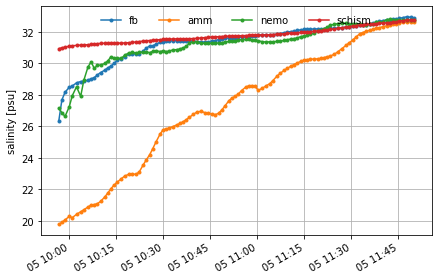

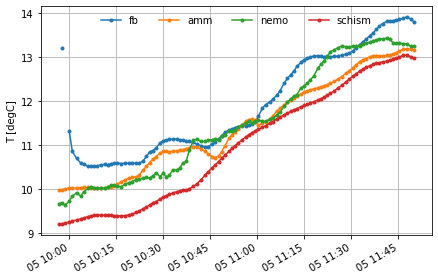

In [20]:
dataname=['fb','amm','nemo','schism']
# Plot results
#plt.subplot(2,1,2)
plt.plot(fb.time,fb.sss,'.-')
plt.plot(amm_trans.time,amm_trans.sss,'.-')
plt.plot(nemo_trans.time,nemo_trans.sss,'.-')
plt.plot(schism_trans.time,schism_trans.sss,'.-')
plt.gcf().autofmt_xdate()
plt.grid()
plt.tight_layout()
plt.legend(dataname,ncol=4,loc='upper center',frameon=False)
plt.ylabel('salinity [psu]')
plt.savefig(out_path+'salt_timeseries.png',dpi=250)

plt.figure()
plt.plot(fb.time,fb.sst,'.-')
plt.plot(amm_trans.time,amm_trans.sst,'.-')
plt.plot(nemo_trans.time,nemo_trans.sst,'.-')
plt.plot(schism_trans.time,schism_trans.sst,'.-')
plt.gcf().autofmt_xdate()
plt.grid()
plt.tight_layout()
plt.legend(dataname,ncol=4,loc='upper center',frameon=False)
plt.ylabel('T [degC]')
plt.savefig(out_path+'temp_timeseries.png',dpi=250)

The graphs show that while SCHISM more strongly underestimates temperature and AMM15 the salinity, the high resolution NEMO config in total is closes to the data. In the following the basic erros statistics, bias, root mean squared error (rmse) and correlation coefficient, corresponding to the curves are computed and illustrated as a bar plot.

[5.767255091400764, 1.8522684176012718, 1.454408463666268]
total execution took 406.2679033279419 s


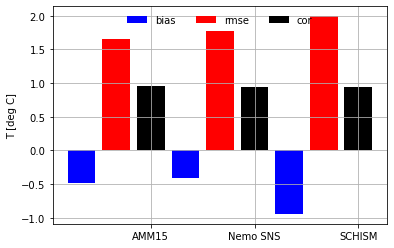

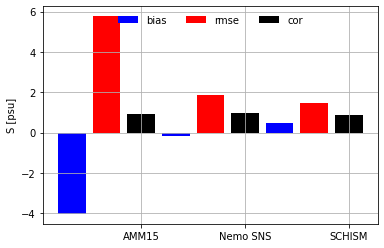

In [21]:
#statistics
class trans_statistics:
    def __init__(self, fb,trans): 
        self.sst_bias=trans.sst.mean()-fb.sst.mean()
        self.sst_rmsd=np.sqrt(np.nanmean((trans.sst-fb.sst)**2))
        ivalid=fb.sst.mask[:,0]==False
        self.sst_corr=np.corrcoef(trans.sst[ivalid],fb.sst[ivalid].flatten())[0,1]
        #self.sst_corr=np.corrcoef(trans.sst[ivalid]-fb.sst[ivalid].flatten())#[0,1]
        self.sss_bias=trans.sss.mean()-fb.sss.mean()
        self.sss_rmsd=np.sqrt(np.nanmean((trans.sss-fb.sss)**2))
        ivalid=fb.sss.mask[:,0]==False
        self.sss_corr=np.corrcoef(trans.sss[ivalid],fb.sss[ivalid].flatten())[0,1]

stats=[trans_statistics(fb,trans) for trans in [amm_trans,nemo_trans,schism_trans]]


# statistics plots
label='T [deg C]'
bias=[stati.sst_bias for stati in stats]
rmse=[stati.sst_rmsd for stati in stats]
cor=[stati.sst_corr for stati in stats]

ph1=plt.bar([1,4,7],bias,color='b')
ph2=plt.bar([2,5,8],rmse,color='r')
ph3=plt.bar([3,6,9],cor,color='k')
plt.legend((ph1,ph2,ph3),('bias','rmse','cor'),ncol=3,loc='upper center',frameon=False)
plt.grid('on')
plt.xticks([3, 6,9],('AMM15','Nemo SNS','SCHISM'))
plt.ylabel(label)
plt.savefig(out_path+'temp_barplot.png',dpi=250)

plt.figure()
label='S [psu]'
bias=[stati.sss_bias for stati in stats]
rmse=[stati.sss_rmsd for stati in stats]
cor=[stati.sss_corr for stati in stats]
# statistics plots
print(rmse)
ph1=plt.bar([1,4,7],bias,color='b')
ph2=plt.bar([2,5,8],rmse,color='r')
ph3=plt.bar([3,6,9],cor,color='k')
plt.legend((ph1,ph2,ph3),('bias','rmse','cor'),ncol=3,loc='upper center',frameon=False)
plt.grid('on')
plt.xticks([3, 6,9],('AMM15','Nemo SNS','SCHISM'))
plt.ylabel(label)
plt.savefig(out_path+'salt_barplot.png',dpi=250)



The statistics summarize to a stronger negative temperature bias for SCHISM and an along track correlation close to one for all three models. For the salinity statistics also a correlation close to one appears for all models replicating the salinity increase from the estuarine to the open ocean areas, but with much stronger salintiy bias and rmse for the coarser AMM15 product, whic under estimates the near shore salinities.

# 6) Conclusion

[Go back to the "Table of contents"](#Table-of-contents)

<div class="alert alert-block alert-success">
    <b>CONGRATULATIONS</b><br>
  
--- 

#### Now you completed the exercies on validating the physical model data provided by Copernicus Marine Service and Hereon with lagrangian FerryoBox measurements.
    
    

#### This use case demonstration is part of the immerse activites.